# Recreating GPT-2 Language Model with PyTorch

Welcome to this project! In this notebook, we will recreate the architecture of the GPT-2 language model using PyTorch, inspired by Andrej Karpathy's code. GPT-2 is a powerful generative model developed by OpenAI, known for its ability to generate coherent and contextually relevant text. The model is based on the Transformer architecture, which has become a foundational building block for many state-of-the-art language models.

This notebook is designed for those who are new to the project, and it will walk you through each step of the implementation in a clear and structured way. We will start by understanding the basic building blocks of GPT-2, including self-attention and the Transformer layers, and gradually build up to the full model. 

Feel free to explore the code, modify it, and ask questions as you go along. Let's get started on our journey to understand and implement one of the most influential models in natural language processing!


In [74]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [75]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

In [76]:
# A random seed so as to easily reproduce the results
torch.manual_seed(1337)

In [77]:
# A Dataset consisting of the entirety of Shakespeare's works
# Run the following wget command in your terminal to download the data
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [78]:
# Here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

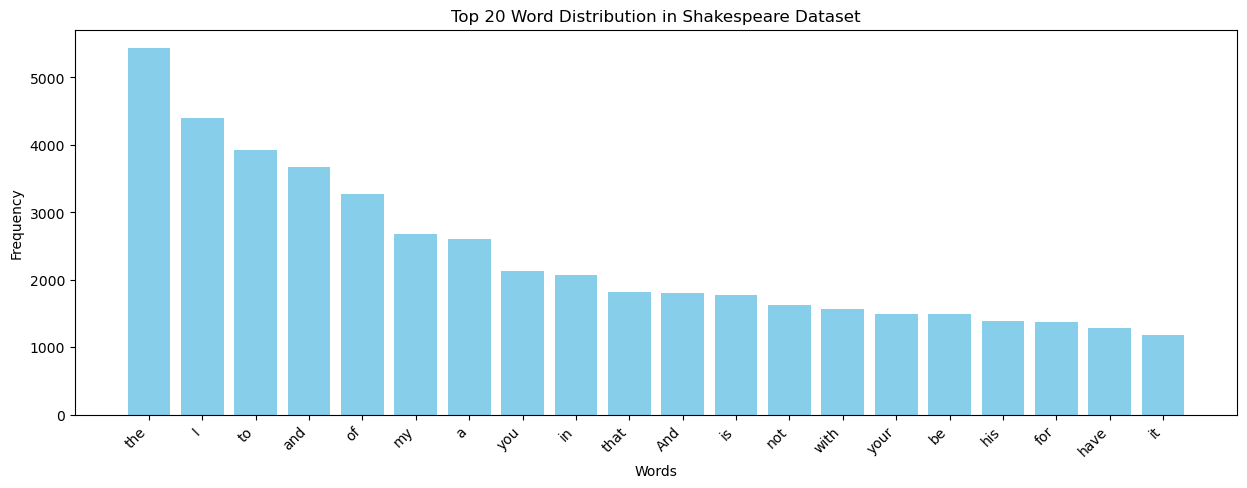

Sample Text:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the text data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Split the text into words
words = text.split()
word_counts = Counter(words)

# Get the 20 most common words for visualization
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# Create a bar plot for word distribution
plt.figure(figsize=(15, 5))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Distribution in Shakespeare Dataset')
plt.show()

# Show a brief sample of text
sample_size = 300  # Display a shorter sample of 300 characters
sample_text = text[:sample_size]

print("Sample Text:\n")
print(sample_text)

In [80]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [81]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

## This Cell Defines the Loss Function

  

The loss function is a crucial component in training any neural network. It quantifies the difference between the model's predictions and the ground truth labels, guiding the model's parameter updates. In this context, we use the **negative log-likelihood (NLL) loss**, which is particularly suited for language modeling tasks. The NLL loss measures how likely the target token sequence is, given the model's predicted probabilities.

  

### Mathematical Description of Negative Log-Likelihood Loss

  

Given a sequence of tokens $X = (x_1, x_2, \dots, x_n)$, the goal of the language model is to predict the probability distribution over the next token $x_{t+1}$ given the previous tokens $(x_1, \dots, x_t)$. Let $P(x_{t+1} \mid x_1, \dots, x_t)$ denote the model's predicted probability of token $x_{t+1}$ being the correct next token.

  

The **negative log-likelihood (NLL) loss** for a single token prediction is given by:

  

$$

\text{Loss}(x_{t+1}) = -\log P(x_{t+1} \mid x_1, \dots, x_t)

$$

  

For a sequence of predictions across a batch of data, the total loss $L$ is the sum of the NLL loss for all tokens in the sequence:

  

$$

L = - \sum_{t=1}^{n} \log P(x_{t+1} \mid x_1, \dots, x_t)

$$

  

Here, $P(x_{t+1} \mid x_1, \dots, x_t)$ is the probability assigned by the model to the correct next token $x_{t+1}$. The model is trained to maximize the likelihood of the correct token sequence, which is equivalent to minimizing the negative log-likelihood loss.

  

### Intuition Behind NLL Loss in Language Modeling

  

The negative log-likelihood loss can be thought of as penalizing the model for assigning low probabilities to the correct next tokens. When the model assigns a high probability to the correct token (e.g., $P(x_{t+1}) \approx 1$), the corresponding loss will be close to zero, indicating a confident and correct prediction. Conversely, if the model assigns a low probability to the correct token, the loss will be large, indicating that the model's prediction was incorrect or uncertain.

  

### Example Calculation of NLL Loss

  

Suppose our language model predicts the next word in a sentence. Given a sentence fragment like "The cat sat on the", the model predicts the next word "mat" with a probability of $P(\text{"mat"}) = 0.8$. The target word is indeed "mat". The negative log-likelihood loss for this prediction is:

  

$$

\text{Loss} = -\log(0.8) \approx 0.223

$$

  

This loss value represents the model's confidence in its prediction. The goal during training is to adjust the model's parameters to minimize this loss, thereby improving the model's ability to generate accurate predictions across the dataset.

  

### Implementation in Code

  

In the provided code, the `estimate_loss()` function estimates the model's loss on both the training and validation datasets. Here's how it works:

  

1. **Evaluation Mode**: The model is set to evaluation mode (`model.eval()`), which disables certain layers like dropout that behave differently during training.

2. **Batch Sampling**: For each dataset split ('train' and 'val'), the function samples batches of data using `get_batch(split)` and computes the loss for each batch.

3. **Loss Calculation**: The function accumulates losses across multiple iterations, stores them in a tensor, and then computes the mean loss for each split.

4. **Training Mode**: After the evaluation, the model is switched back to training mode (`model.train()`).

  

This function provides an estimate of the model's performance on unseen data and helps monitor its learning progress.

In [82]:
# This cell contains the loss function and the model architecture
# What happens if pytorch builds a computation graph and what does building a computation graph mean?
# PyTorch builds a computation graph when it is required to calculate the gradients of the model parameters with respect to the loss function. This is done by keeping track of the operations that are performed on the input data and the model parameters. This computation graph is then used to calculate the gradients using backpropagation.
@torch.no_grad() # This is to prevent PyTorch from building a computation graph which means we don't need to allocate memory for gradients

# This is the loss function that we will use to train the model
# The loss equation is the negative log likelihood of the predicted logits
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out





## Attention Head: Theory and Implementation

In modern deep learning models, **attention mechanisms** have become a key component, particularly in the Transformer architecture, which powers models like GPT-2. The idea of attention allows the model to focus on specific parts of the input sequence when making predictions, which is crucial for handling long-range dependencies in sequences such as text.

### Theory of Self-Attention

Self-attention enables a model to relate different positions in a sequence to each other. For example, in natural language processing (NLP), a word may depend on another word far earlier in the sequence. Self-attention computes a weighted sum of all elements in the sequence for each element, where the weights are determined by the relevance or "attention" paid to other elements.

In mathematical terms, given an input sequence of token embeddings $X$, the self-attention mechanism computes three vectors for each token:
- **Query (Q)**: Represents the token we're currently focusing on.
- **Key (K)**: Represents the token we're comparing against.
- **Value (V)**: Represents the token's content that will contribute to the final output.

The attention scores are computed as the dot product of the Query and Key vectors, scaled by the square root of the dimensionality of the Key vector. This scaling is important to avoid extremely large dot product values, which can result in very small gradients:

$$
\text{Attention Scores} = \frac{Q \cdot K^T}{\sqrt{d_k}}
$$

The attention scores are then passed through a softmax function to convert them into probabilities. These probabilities determine how much focus (or attention) the model should place on each token in the sequence. The final output is a weighted sum of the Value vectors based on these probabilities.

### Masked Self-Attention in Language Models

In autoregressive models like GPT-2, we use **masked self-attention** to ensure that each token can only attend to previous tokens, not future ones. This is critical for generating sequences where future information should not be known during training. The mask is implemented by setting the attention scores of future tokens to negative infinity, effectively preventing them from contributing to the current token's prediction.

### Implementation of an Attention Head

In the provided code, the class `Head` defines a single **attention head**. Here's a breakdown of its components:

- **Linear Layers**: Three linear layers, `self.key`, `self.query`, and `self.value`, are used to project the input embeddings into the Query, Key, and Value vectors, respectively. The dimensionality of these projections is determined by `head_size`.
  
- **Attention Scores**: The attention scores are computed by taking the dot product of the Query and Key matrices. The result is scaled by $\frac{1}{\sqrt{\text{head\_size}}}$ to stabilize gradients.

- **Masking**: A lower triangular matrix (`self.tril`) is used to mask out future tokens, ensuring that each token only attends to previous tokens (causal self-attention).

- **Softmax**: The masked attention scores are passed through a softmax function to convert them into attention probabilities.

- **Weighted Aggregation**: The attention probabilities are then used to compute a weighted sum of the Value vectors, resulting in the output for this attention head.

- **Dropout**: A dropout layer is applied to the attention weights to prevent overfitting during training.

The output of this attention head is a weighted combination of the values, where the weights are determined by the attention mechanism. This enables the model to selectively focus on relevant parts of the input sequence when making predictions.

In [85]:
# Important parameters for this class
# This class is a transformer model that is used for language modeling
# The model consists of an embedding layer, a stack of transformer blocks, and a linear layer
# The embedding layer is used to convert the input tokens into a continuous representation
# The transformer blocks are used to process the continuous representation
# The linear layer is used to convert the continuous representation into logits for the output tokens

# Important parameters for this class
n_embd = 384  # embedding dimension
n_head = 6  # number of attention heads
block_size = 256  # maximum context length
dropout = 0.1  # dropout probability
batch_size = 1  # for visualization, we'll use a single batch


# n_embd = 384 # embedding dimension, meaning that each token will be represented as a vector of size 384 and the number of dimesions in our embedding space is 384
# n_head = 6 # number of attention heads, meaning that the input tokens will be processed by 6 different attention heads in parallel




# This defines an attention head
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B, T, hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out, wei

# Tokenization and embedding
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Encode and decode functions
chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Example sequence from the dataset
sample_text = "I think, therefore I am."
tokens = encode(sample_text)  # Convert the sample text to a sequence of integers
tokens = torch.tensor(tokens).unsqueeze(0)  # Shape (1, T)

# Ensure tokens length does not exceed block_size
tokens = tokens[:, :block_size]

# Create a random embedding layer for visualization purposes
embedding = nn.Embedding(len(chars), n_embd)
x = embedding(tokens)  # Embed the tokens, shape (1, T, n_embd)

# Instantiate the attention head
head_size = n_embd // n_head
head = Head(head_size)

# Perform a forward pass through the attention head
out, attention_map = head(x)

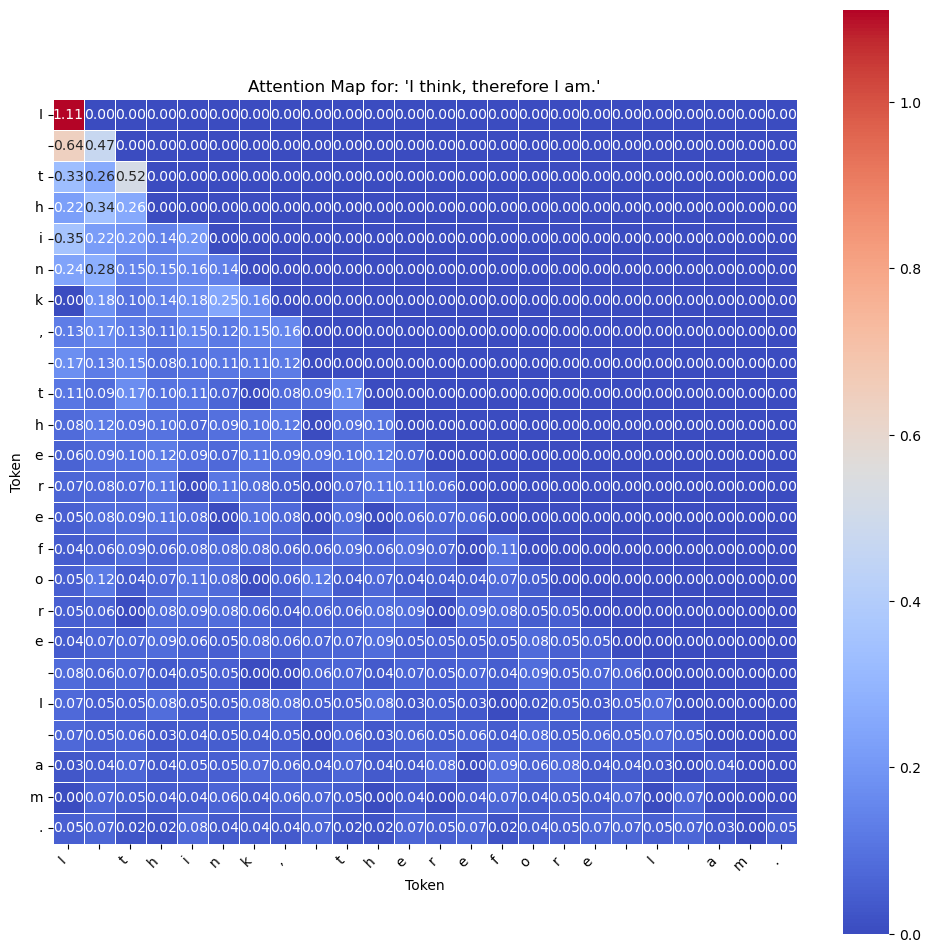

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_attention_map(attention_map, tokens, sample_text, itos):
    # Convert attention map to numpy array for better compatibility with visualization libraries
    attention_map = attention_map[0].detach().cpu().numpy()
    
    # Convert token indices to actual tokens
    token_labels = [itos[token.item()] for token in tokens]
    
    # Create a DataFrame for better control over plot aesthetics
    df = pd.DataFrame(attention_map, index=token_labels, columns=token_labels)
    
    plt.figure(figsize=(12, 12))
    sns.heatmap(df, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, linewidths=.5, square=True)
    
    plt.title(f"Attention Map for: '{sample_text}'")
    plt.xlabel("Token")
    plt.ylabel("Token")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.yticks(rotation=0)  # Keep y labels horizontal
    plt.show()

# Example usage
plot_attention_map(attention_map, tokens[0], sample_text, itos)


In your code, the tokens represent indices of characters (or words) in the vocabulary of the text. For example, each character in the input text `"I think, therefore I am."` is converted into an integer token based on its position in the character vocabulary.

Here’s how it works:

1. **Tokenization**: The input text is tokenized into characters or words. Each character (or word) is assigned a unique index. For example, in the string `"I think, therefore I am."`, each character (including spaces and punctuation) is given a unique token.

2. **Embedding**: These integer tokens are then mapped to continuous vectors using the embedding layer. This process converts the discrete tokens into continuous representations suitable for processing by the model.

3. **Attention Map**: The attention map generated shows how much attention each token in the sequence pays to every other token. The values in the attention map reflect these relationships.

### Example Token Mapping

For instance, if you have the following character set and their corresponding indices:

```python
chars = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
```

And the encoding function might look like:

```python
stoi = {ch: i for i, ch in enumerate(chars)}
```

Then a sample text `"I think, therefore I am."` could be encoded as:

```python
tokens = [stoi[ch] for ch in sample_text]  # [39, 46, 55, 58, 44, ...]
```

Here, each index corresponds to a character in your `chars` list.

### In Summary

- **Tokens**: In your setup, tokens are likely individual characters or words, depending on your tokenization method.
- **Visualization**: When you visualize the attention map, the x and y axes represent these tokens, so the attention map will show how each token relates to every other token in the sequence.

If you want to visualize relationships between actual tokens (characters or words) in the attention map, ensure that your axis labels correspond to the actual characters or words used in your sequence.

## Multi-Head Attention: Theory and Implementation

In the Transformer architecture, **multi-head attention** is a key component that allows the model to jointly attend to information from different representation subspaces. This mechanism enables the model to focus on different aspects of the input sequence simultaneously, capturing diverse patterns and relationships within the data.

### Theory of Multi-Head Attention
In multi-head attention, the input embeddings are projected into multiple subspaces using linear transformations. Each subspace is then processed by a separate attention head, which computes its own attention scores and output. The outputs from all attention heads are concatenated and linearly transformed to produce the final multi-head attention output.

In [87]:
# This class defines a multi-head attention mechanism
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Define a list of attention heads
        self.proj = nn.Linear(head_size * num_heads, n_embd) # Define a linear projection layer to combine the outputs of all heads
        self.dropout = nn.Dropout(dropout) # Define a dropout layer to prevent overfitting, this means that some of the outputs will be randomly set to zero

    #def forward(self, x):
    #    out = torch.cat([h(x) for h in self.heads], dim=-1) # Loops through all the attention heads, runs a forward pass through each head, and concatenates the outputs
    #    out = self.dropout(self.proj(out)) # Apply dropout and linear projection to the concatenated outputs
    #    return out
    
    def forward(self, x):
        # Collect the outputs from all heads, ignoring the attention weights
        head_outputs = []
        for h in self.heads:
            out, _ = h(x)  # Ignore the `wei` (attention weights) by using an underscore
            head_outputs.append(out)
        
        # Concatenate all head outputs
        out = torch.cat(head_outputs, dim=-1)  # Concatenate along the embedding dimension
        out = self.dropout(self.proj(out))  # Apply dropout and linear projection

        return out  # Only return the concatenated output


In [88]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        # Define a feedforward neural network with a single hidden layer
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # An input layer with n_embd neurons and an output layer with 4*n_embd neurons
            nn.ReLU(),                     # A ReLU activation function
            nn.Linear(4 * n_embd, n_embd), # An output layer with n_embd neurons
            nn.Dropout(dropout),           # A dropout layer to prevent overfitting
        )

    def forward(self, x):
        return self.net(x) # Returns the output of the feedforward neural network with input x

In [89]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        # We divide up the embedding space into n_head different pieces
        head_size = n_embd // n_head # Defines the size of each attention head, size means the number of dimensions in the output of each head
        
        # Defining the layers of the Transformer block
        self.sa = MultiHeadAttention(n_head, head_size) # Define sa as a multi-head attention mechanism with n_head heads and head_size dimensions
        self.ffwd = FeedFoward(n_embd)                  # Define ffwd as a feedforward neural network with n_embd dimensions
        self.ln1 = nn.LayerNorm(n_embd)                 # Define ln1 as a layer normalization layer with n_embd dimensions
        self.ln2 = nn.LayerNorm(n_embd)                 # Define ln2 as a layer normalization layer with n_embd dimensions

    def forward(self, x):
        # Perform a forward pass through the Transformer block
        x = x + self.sa(self.ln1(x)) # Apply multi-head attention, layer normalization, and add the input to the output
        x = x + self.ffwd(self.ln2(x)) # Apply the feedforward neural network, layer normalization, and add the input to the output
        # We add input to the output to retain the original information
        return x

In [90]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [91]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10.788929 M parameters
step 0: train loss 4.3502, val loss 4.3544
step 500: train loss 2.5405, val loss 2.5474
step 1000: train loss 2.5273, val loss 2.5095
step 1500: train loss 2.4873, val loss 2.5105
step 2000: train loss 2.4661, val loss 2.4925
step 2500: train loss 2.4508, val loss 2.4879
step 3000: train loss 2.3556, val loss 2.3927
step 3500: train loss 2.2041, val loss 2.2393
step 4000: train loss 2.1191, val loss 2.1797
step 4500: train loss 2.0555, val loss 2.1339
step 4999: train loss 2.0309, val loss 2.1193

ONIONUYIO, cand youlort.
PREESTIUS:
Art shorshat hodd I woas one hatis ther
And what sheatay wor tould you dan ance mu ofd sunt wer the vorctad this he the ass bome.
In l sI pill.

CLANUS:
ThELO:
Sod lal?
Youlinst dowerther doseave muce ware, arldsell rell st coste sbe,
Be mEing and o'er bellear men hadonds hoe pand go tret st,
Wircom har statell bth,
I of: th siresinh lavandient. speor,
Your A his swal cud. do thing mest a the ibtur ol that th'd the with t orve'ey for 